### 📊 **Informe: Modelo de Clasificación de Género de Películas**

### 👥 Integrantes
- Miguel Mateo Sandoval Torres  
- Diego Dayan Niño Pérez  
- Camilo Andrés Flórez Esquivel  
- Andrea Amariles Escobar  

### 📚 Curso
**Machine Learning y Procesamiento de Lenguaje Natural**

### 🗓️ Fecha
**Mayo de 2025**

### **Introducción** <br>
<p style="text-align: justify;">
Este informe presenta el desarrollo de un modelo de aprendizaje automático, cuyo objetivo es predecir la probabilidad de que una película pertenezca a un género en particular. A lo largo del documento se describen las etapas fundamentales del proceso, incluyendo el preprocesamiento de datos, la selección y calibración del modelo, el entrenamiento y evaluación del rendimiento del mismo, al igual que métricas comparativas con versiones alternativas, con el objetivo de evidenciar el proceso de selección del modelo final. Finalmente, se presenta el procedimiento de disponibilización del modelo predictivo mediante una API.<p>

In [ ]:
# Importación librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import ast
from itertools import chain
from collections import Counter
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
# Recursos
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.word_tokenize("example")
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

### **Carga y Preprocesamiento de Datos**

In [ ]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

# Visualización datos de entrenamiento
dataTraining.head()

# Visualización datos de test
dataTesting.head()

In [ ]:
# Revisión general de los datos
nulos = dataTraining.isnull().sum()               # Busqueda de valores nulos
duplicados = dataTraining.duplicated().sum()      # Busqueda de valores repetidos
titulos_unicos = dataTraining['title'].nunique()  # Títulos únicos de películas
dataTraining.info()                               # Información general de los datos

print(f'Valores nulos:\n{nulos}')
print(f'\nValores duplicados: {duplicados}')
print(f'\nCantidad de títulos únicos: {titulos_unicos}')

In [ ]:
# Conversión de la columna 'genres' de string a lista
dataTraining['genres_list'] = dataTraining['genres'].apply(ast.literal_eval)

In [ ]:
# Visualización de películas por género
frecuencia_generos = list(chain.from_iterable(dataTraining['genres_list']))
conteo_generos = Counter(frecuencia_generos)

sorted_genres = conteo_generos.most_common()
genres, counts = zip(*sorted_genres)

plt.figure(figsize=(12, 6))
bars = plt.bar(genres, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Género')
plt.ylabel('Cantidad de películas')
plt.title('Frecuencia de géneros en el dataset')
plt.tight_layout()

# Paso 5: Añadir etiquetas a cada barra
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(count), ha='center', va='bottom', fontsize=9)

plt.show()

A continuación, se definen algunas funciones de preporcesamiento de texto que serán aplicadas más adelante sobre los datos de entrada para entrenar los modelos predictivos:

In [ ]:
# Inicialización de herramientas
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Función de preprocesamiento de texto 
def preprocess_text_1(text):
    """
    Esta es una función de preprocesamiento de texto que realiza las siguientes tareas:
    - Convierte el texto a minúsculas.
    - Elimina caracteres no alfabéticos.
    - Tokeniza el texto en palabras individuales.
    - Elimina stopwords y palabras de menos de 3 letras.
    - Lematiza cada palabra (reduce a su forma base).
    - Devuelve el texto limpio como una cadena de palabras separadas por espacios.

    Parámetros:
        text (str): Texto de entrada.

    Retorna:
        str: Texto preprocesado para análisis o modelado.
    """
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
        return ' '.join(tokens)
    return ''

In [ ]:
# Función de procesamiento de texto con BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

def get_bert_embedding(text):
    """
    Genera un embedding numérico para un texto utilizando BERT.
    - Tokeniza el texto de entrada usando el tokenizer de BERT preentrenado.
    - Procesa el texto con el modelo BERT para obtener los embeddings de cada token.
    - Calcula el promedio de los embeddings de todos los tokens para obtener una única representación del texto.
    - Devuelve el embedding como un vector de NumPy.

    Parámetros:
        text (str): Texto de entrada a convertir en embedding.

    Retorna:
        np.ndarray: Vector numérico que representa el significado del texto según BERT.
    """
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        outputs = bert_model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        embedding = last_hidden_state.mean(dim=1)
        return embedding.squeeze().numpy()

### **Entrenamiento de Modelos Predictivos**

Se entrenaron y calibraron diferentes modelos predictivos. A continuación se presentan tres modelos a partir de los cuales se eligió el que presentó el mejor desempeño:

#### Modelo 1: Regresión Logística con NLTK y CountVectorizer

In [ ]:
# Aplicar preprocesamiento a los datos de entrenamiento (limpieza, tokenización y lematización)
dataTraining['plot_clean_1'] = dataTraining['plot'].apply(preprocess_text_1)
dataTesting['plot_clean_1'] = dataTesting['plot'].apply(preprocess_text_1)

# Aplicación de CountVectorizer para convertir texto en matriz numérica
vect = CountVectorizer(max_features=1000)
X_dtm_1 = vect.fit_transform(dataTraining['plot_clean_1'])
X_dtm_1.shape

# Codificación de etiquetas de salida (géneros)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [32]:
# División de los datos en entrenamiento y prueba
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm_1, y_genres, 
                                                                  test_size=0.33, 
                                                                  random_state=42
                                                                  )
# Clasificador Regresión Logística y One-vs-Rest
clf = OneVsRestClassifier(LogisticRegression(n_jobs=-1, max_iter=1000, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción
y_pred_genres = clf.predict_proba(X_test)

# Evaluación
AUC_LogReg_nltk = roc_auc_score(y_test_genres, y_pred_genres, average='macro')

#### Modelo 2: Regresión Logística con Embeddings BERT y One-vs-Rest

In [ ]:
dataTraining['plot_clean_bert'] = dataTraining['plot'].apply(get_bert_embedding)
dataTesting['plot_clean_bert'] = dataTesting['plot'].apply(get_bert_embedding)

X_bert = np.vstack(dataTraining['plot_clean_bert'].values)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_bert, y_genres, 
                                                                  test_size=0.33, 
                                                                  random_state=42
                                                                  )
# # Clasificador Regresión Logística y One-vs-Rest
clf = OneVsRestClassifier(LogisticRegression(n_jobs=-1, max_iter=1000, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
AUC_LogReg_BERT = roc_auc_score(y_test_genres, y_pred_genres, average='macro')

#### Modelo 3: Red Neuronal

### **Comparación y Selección del Mejor Modelo**

In [29]:
AUC_LogReg_nltk = 0.8074515158472976
AUC_LogReg_BERT = 0.9115145990868244
AUC_RedNeuronal = 0.9370

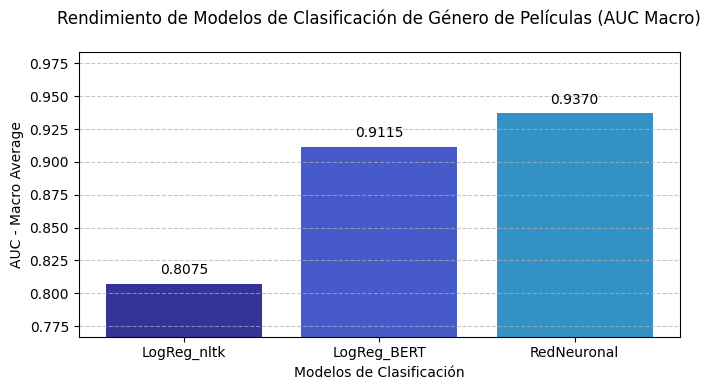

In [30]:
modelos = ['LogReg_nltk', 'LogReg_BERT', 'RedNeuronal']
AUC = [AUC_LogReg_nltk , AUC_LogReg_BERT, AUC_RedNeuronal]

# Crear un DataFrame temporal para ordenar los datos
df_resultados = pd.DataFrame({'Modelo': modelos, 'AUC': AUC})
df_resultados = df_resultados.sort_values(by='AUC', ascending=True)

fig, ax = plt.subplots(figsize=(7, 4))
colors = ['#000080', '#1630BE', '#0077b6']

# Gráfico de barras
bars = ax.bar(df_resultados['Modelo'], df_resultados['AUC'], color=colors, alpha=0.8)
ax.set_title('Rendimiento de Modelos de Clasificación de Género de Películas (AUC Macro)', fontsize=12, pad=20)
ax.set_xlabel('Modelos de Clasificación', fontsize=10)
ax.set_ylabel('AUC - Macro Average', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar los valores de AUC en las barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.005, f'{height:.4f}',
            ha='center', va='bottom', fontsize=10, color='black')

min_auc = min(AUC) * 0.95
max_auc = max(AUC) * 1.05
ax.set_ylim(min_auc, max_auc)

plt.tight_layout()
plt.show()

### **Disponibilización del Modelo**